In [54]:
import pandas as pd
import numpy as np
import os, time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, roc_auc_score, f1_score
from sklearn.model_selection import cross_val_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.mixture import GaussianMixture as EM
from sklearn.ensemble import RandomForestClassifier as RFC
# from sklearn.random_projection import GaussianRandomProjection as GRP, SparseRandomProjection as RCA
# from sklearn.metrics.pairwise import pairwise_distances

from helpers import *

# Preprocess Data

In [2]:
SEED = 903653851 # my GTID
cur_dir = os.getcwd()

# Source: https://archive.ics.uci.edu/ml/datasets/Bank+Marketing#
df_bm = pd.read_csv(cur_dir + "/data/bank/bank-full" + ".csv", delimiter=';')
# df_ie = pd.read_csv(cur_dir + "/data/income/income_evaluation_clean" + ".csv", delimiter=';')

#### Bank Marketing

In [3]:
# df_bm.isnull().sum() # checking for nulls, otherwise fill missing values with mean of all values in column

In [4]:
# "age";"job";"marital";"education";"default";"balance";"housing";"loan";"contact";"day";"month";"duration";"campaign";"pdays";"previous";"poutcome";"y"
one_hot_cols = ['job','marital','education','default','housing','loan','contact','month','poutcome']
df_one_hot_cols = df_bm[one_hot_cols]
df_one_hot = pd.get_dummies(df_one_hot_cols).astype('category')
df_rest = df_bm.drop(one_hot_cols, axis=1)
df_bm = pd.concat([df_rest, df_one_hot], axis=1)


In [5]:
# Normalization
numerical_cols = ['age','balance','day','duration','campaign','pdays','previous']
df_nums = df_bm[numerical_cols]
df_normalized = (df_nums - df_nums.min()) / (df_nums.max() - df_nums.min())
df_bm_categoricals = df_bm.drop(numerical_cols, axis=1)
df_bm = pd.concat([df_bm_categoricals, df_normalized], axis=1)

# Convert categories to numeric values, put label at the end
new_cols = df_bm.columns.to_list()
new_cols.pop(new_cols.index('y'))
df_bm = df_bm[new_cols + ['y']]
df_bm['y'].replace("yes", 1, inplace=True)
df_bm['y'].replace("no", 0, inplace=True)
df_bm['y'] = df_bm['y'].astype('category')

#### Income Evaluation

In [6]:
''' Needs to be run only once. '''
# Source: https://www.kaggle.com/lodetomasi1995/income-classification
# with open(cur_dir + "/data/income/income_evaluation_clean" + ".csv", 'a') as clean_file:
#     ie_clean = csv.writer(clean_file)
#     with open(cur_dir + "/data/income/income_evaluation" + ".csv", 'r') as ie_file:
#         ie_data = csv.reader(ie_file, delimiter=',')
#         for line in ie_data:
#             row = []
#             for cell in line:
#                 if cell[0] == ' ': cell = cell[1:]
#                 if cell[-1] == ' ': cell = cell[:-1]
#                 row.append(cell)
#             ie_clean.writerow(row)

' Needs to be run only once. '

In [7]:
df_ie = pd.read_csv(cur_dir + "/data/income/income_evaluation_clean" + ".csv", delimiter=',')
print("Data has",len(df_ie),"rows and", len(df_ie.columns),"columns.")
# df_ie.isnull().sum() # checking for nulls, otherwise fill missing values with mean of all values in column

In [8]:
# age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
one_hot_cols = ['workclass','education','marital-status','occupation','relationship','race','sex','native-country']
df_one_hot_cols = df_ie[one_hot_cols]
df_one_hot = pd.get_dummies(df_one_hot_cols).astype('category')
df_rest = df_ie.drop(one_hot_cols, axis=1)
df_ie = pd.concat([df_rest, df_one_hot], axis=1)


In [9]:
# Normalization
numerical_cols = ['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']
df_nums = df_ie[numerical_cols]
df_normalized = (df_nums - df_nums.min()) / (df_nums.max() - df_nums.min())
df_ie_categoricals = df_ie.drop(numerical_cols, axis=1)
df_ie = pd.concat([df_ie_categoricals, df_normalized], axis=1)

# Convert categories to numeric values, put label at the end
new_cols = df_ie.columns.to_list()
new_cols.pop(new_cols.index('income'))
df_ie = df_ie[new_cols + ['income']]
df_ie['income'].replace(">50K", 1, inplace=True)
df_ie['income'].replace("<=50K", 0, inplace=True)
df_ie['income'] = df_ie['income'].astype('category')

# Bank Marketing

In [10]:
X, y = getXy(df_bm)
splits = get_splits(df_bm, 0.2)
X_train, X_test, y_train, y_test = splits

In [11]:
sns.set_theme(style="whitegrid")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

DATASET = "BM"


# Run Clustering Algorithms on the Datasets

### K-Means

In [44]:
def run_kmeans(X_train_scaled, dataset, DR_algo=None):
    km_estimator = KMeans(random_state=SEED, algorithm="auto")

    visulizer_s = KElbowVisualizer(km_estimator, k=(2,31), metric="silhouette")
    visulizer_s.fit(X_train_scaled)
    visulizer_s.finalize()
    plt.savefig(f"{os.getcwd()}/plots/{dataset}{' ('+DR_algo+')' if DR_algo else ''} - K-Means_Silhouette")
    plt.show(); plt.close()

    visulizer_d = KElbowVisualizer(km_estimator, k=(2,31), metric='distortion')
    visulizer_d.fit(X_train_scaled)
    visulizer_d.finalize()
    plt.savefig(f"{os.getcwd()}/plots/{dataset}{' ('+DR_algo+')' if DR_algo else ''} - K-Means_Distortion")
    plt.show(); plt.close()

    num_clusters = np.arange(2,31)
    train_durations = []
    inertias = []
    for k in num_clusters:
        start_time = time.time()
        estimator = KMeans(n_clusters=k, random_state=SEED).fit(X_train_scaled)
        end_time = time.time()
        estimator.fit(X_train_scaled)
        inertias.append(estimator.inertia_)
        train_durations.append(end_time - start_time)

    inertias = np.array(inertias)
    plt.title(f"k-clusters vs. Inertia - {dataset}{' ('+DR_algo+')' if DR_algo else ''}")
    plt.plot(num_clusters, inertias, color="g")
    plt.xlabel('k-clusters')
    plt.ylabel('Inertia')
    plt.grid(True); plt.tight_layout()
    plt.savefig(f"{os.getcwd()}/plots/{dataset}{' ('+DR_algo+')' if DR_algo else ''} - K-Means_Inertia")
    plt.show(); plt.close()
    return num_clusters, train_durations




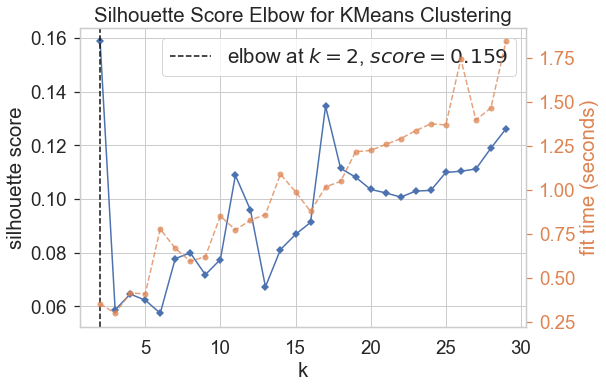

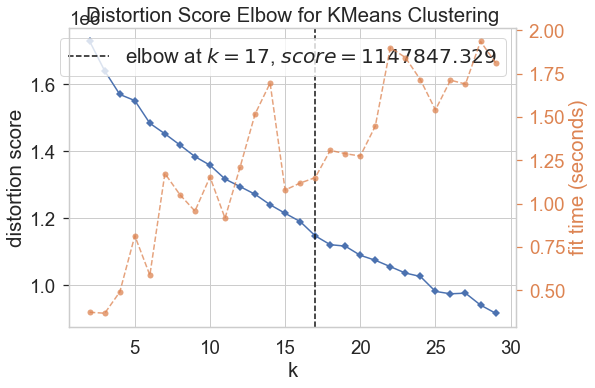

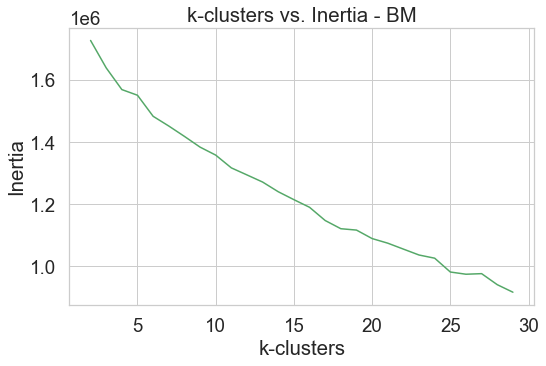

In [45]:
num_clusters, kmeans_durations = run_kmeans(X_train_scaled, DATASET)

### Expectation Maximization

In [46]:
def execute_EM(X_train_scaled, dataset, DR_algo=None):

    n_components_lst = np.arange(2,31)
    train_durations = []
    aic_scores, bic_scores, ll_scores, sil_scores = [], [], [], []

    for k in n_components_lst:
        start_time = time.time()
        em = EM(n_components=k, random_state=SEED, warm_start=True).fit(X_train_scaled)
        end_time = time.time()
        train_durations.append(end_time - start_time)

        aic_scores.append(em.aic(X_train_scaled))
        bic_scores.append(em.bic(X_train_scaled))
        ll_scores.append(em.score(X_train_scaled))
        labels = em.predict(X_train_scaled)
        sil_scores.append(silhouette_score(X_train_scaled, labels))

    # plot elbow curve for silhouette score
    plt.title(f"Elbow Method for Expectation Maximization - {dataset}{' ('+DR_algo+')' if DR_algo else ''}")
    plt.plot(n_components_lst, sil_scores, "-o")
    plt.xlabel("Number of Distributions")
    plt.ylabel("Mean Silhouette Score")
    plt.grid(True); plt.tight_layout()
    plt.savefig(f"{os.getcwd()}/plots/{dataset}{' ('+DR_algo+')' if DR_algo else ''} - EM_Silhouette")
    plt.show(); plt.close()
    
    # plot log-likelihood
    plt.title(f"LogLikelihood EM - {dataset}{' ('+DR_algo+')' if DR_algo else ''}")
    plt.plot(n_components_lst, ll_scores,"-o")
    plt.xlabel("Number of Distributions")
    plt.ylabel("Log-Likelihood Score")
    plt.grid(True); plt.tight_layout()
    plt.savefig(f"{os.getcwd()}/plots/{dataset}{' ('+DR_algo+')' if DR_algo else ''} - EM_Loglikelihood")
    plt.show(); plt.close()

    # plot AIC and BIC
    plt.title(f"EM Model Complexity - {dataset}{' ('+DR_algo+')' if DR_algo else ''}")
    plt.plot(n_components_lst, aic_scores, "-o", label="AIC")
    plt.plot(n_components_lst, bic_scores, "-o", label="BIC")
    plt.xlabel("Number of Distributions")
    plt.ylabel("Model Complexity Score")
    plt.legend()
    plt.grid(True); plt.tight_layout()
    plt.savefig(f"{os.getcwd()}/plots/{dataset}{' ('+DR_algo+')' if DR_algo else ''} - EM_AIC_BIC")
    plt.show(); plt.close()
    
    return n_components_lst, train_durations


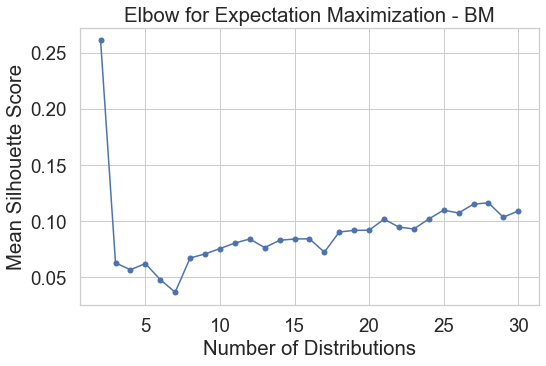

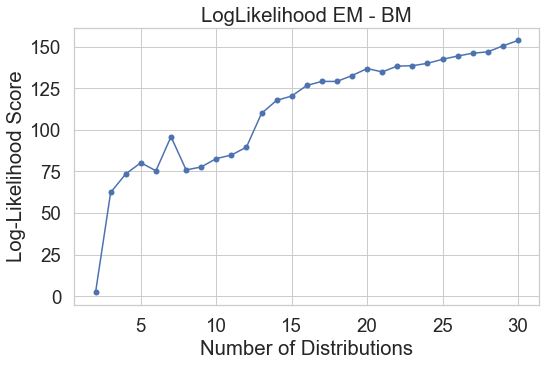

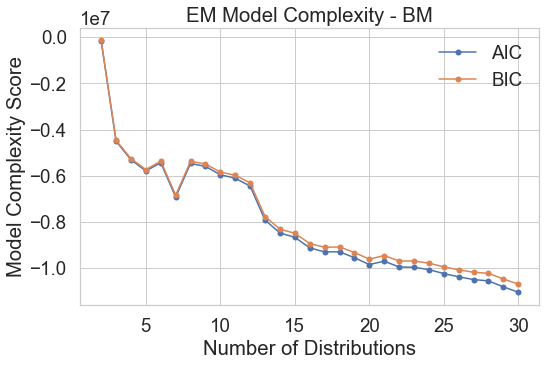

In [47]:
n_components_lst, em_durations = execute_EM(X_train_scaled, DATASET)

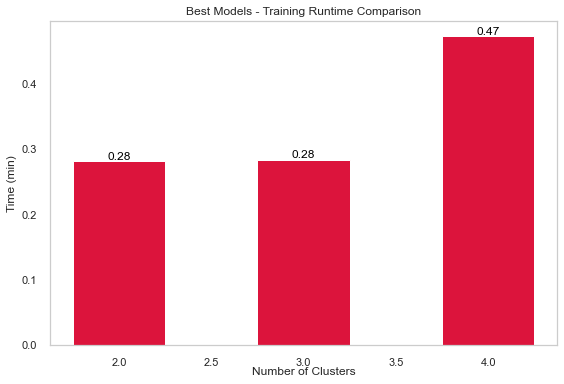

In [33]:

fix, ax = plt.subplots()
plt.title(f"K-Means Training Runtime")
ax.bar(num_clusters, kmeans_durations, width=0.5, color='crimson')
for i,v in enumerate(kmeans_durations):
    plt.text(i+2, v, f"{v:.2f}", color="black", fontsize=12, ha="center", va="bottom")
plt.xlabel("Number of Clusters", va="center")
plt.ylabel("Time (min)")
plt.tight_layout()
plt.grid()
plt.show()
# plt.savefig(f"{DATASET} - Best_Models_Training_Runtime_Comparison")

# Apply Dimensionality Reduction on Datasets

### PCA

In [48]:
from sklearn.decomposition import PCA, FastICA
def execute_PCA(X_train_scaled, orig_data, dataset, n_components=None, DR_algo=None):

    pca = PCA(random_state=SEED).fit(X_train_scaled) if n_components==None else PCA(n_components=n_components, random_state=SEED).fit(X_train_scaled)
    cum_variance = np.cumsum(pca.explained_variance_ratio_)
    best_idx = [np.argmax(abs(c)) for c in pca.components_]
    best_features = [orig_data.columns[i] for i in best_idx]

    plt.title(f"PCA Component vs Cumulative Variance - {dataset}{' ('+DR_algo+')' if DR_algo else ''}")
    plt.plot(np.arange(1, pca.explained_variance_ratio_.size + 1), pca.explained_variance_ratio_, label='Variance')
    plt.plot(np.arange(1, pca.explained_variance_ratio_.size + 1), cum_variance, label='Cum. Variance')
    plt.xticks(np.arange(1, pca.explained_variance_ratio_.size + 1, 2))
    plt.xlabel('Number of Components')
    plt.ylabel('Variance')
    plt.legend()
    plt.grid(True); plt.tight_layout()
    plt.savefig(f"{os.getcwd()}/plots/{dataset}{' ('+DR_algo+')' if DR_algo else ''} - PCA_Cum_Var")
    plt.show(); plt.close()

    return pca, best_features

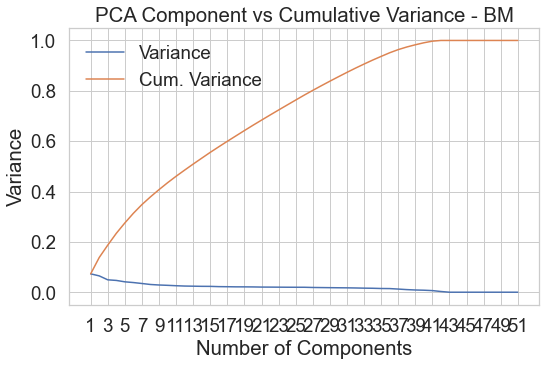

In [49]:
pca, pca_best_features = execute_PCA(X_train_scaled, df_bm, "BM")

### ICA

In [50]:
def execute_ICA(X_train_scaled, dataset, DR_algo=None):

    dimensions = np.arange(2,31)
    ica = FastICA(random_state=SEED)
    kurtosis_vals = []

    for d in dimensions:
        ica.set_params(n_components=d)
        S_ = ica.fit_transform(X_train_scaled) # Reconstruct signals
        S_ = pd.DataFrame(S_)
        S_ = S_.kurt(axis=0)
        kurtosis_vals.append(S_.abs().mean())

    plt.title(f"ICA Kurtosis - {dataset}{' ('+DR_algo+')' if DR_algo else ''}")
    plt.xlabel("Independent Components")
    plt.ylabel("Mean Kurtosis")
    plt.plot(dimensions, kurtosis_vals, 'o-')
    plt.grid(True); plt.tight_layout()
    plt.savefig(f"{os.getcwd()}/plots/{dataset}{' ('+DR_algo+')' if DR_algo else ''} - ICA_Kurtosis")
    plt.show(); plt.close()

    return ica


/usr/local/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


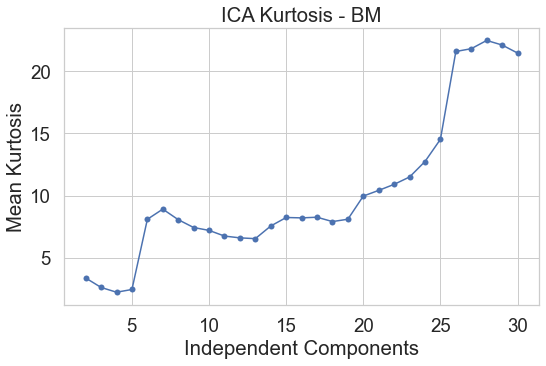

In [51]:
ica = execute_ICA(X_train_scaled, "BM")

### Random Forest

In [55]:
# from IPython.display import display

def run_RFC(X_train_scaled, y_train, dataset, DR_algo=None):
    rfc = RFC()
    rfc.fit(X_train_scaled, y_train)
    # display(rfc.score(X_train_scaled, y_train))

    feats = {}
    for feature, importance in zip(df_bm.columns, rfc.feature_importances_):
        feats[feature] = importance
    importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
    importances = importances.sort_values(by='Gini-Importance', ascending=False)
    importances = importances.reset_index()
    importances = importances.rename(columns={'index': 'Features'})
    sns.set(font_scale = 5)
    sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
    fig, ax = plt.subplots()
    fig.set_size_inches(30,15)
    plt.title(f"Feature Importance - {dataset}{' ('+DR_algo+')' if DR_algo else ''}")
    sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='g')
    plt.xlabel('Gini-Importance', fontsize=25, weight = 'bold')
    plt.ylabel('Features', fontsize=25, weight = 'bold')
    plt.grid(True); plt.tight_layout()
    plt.savefig(f"{os.getcwd()}/plots/{dataset}{' ('+DR_algo+')' if DR_algo else ''} - RFC_Gini_Importance")
    plt.show(); plt.close()

    return rfc



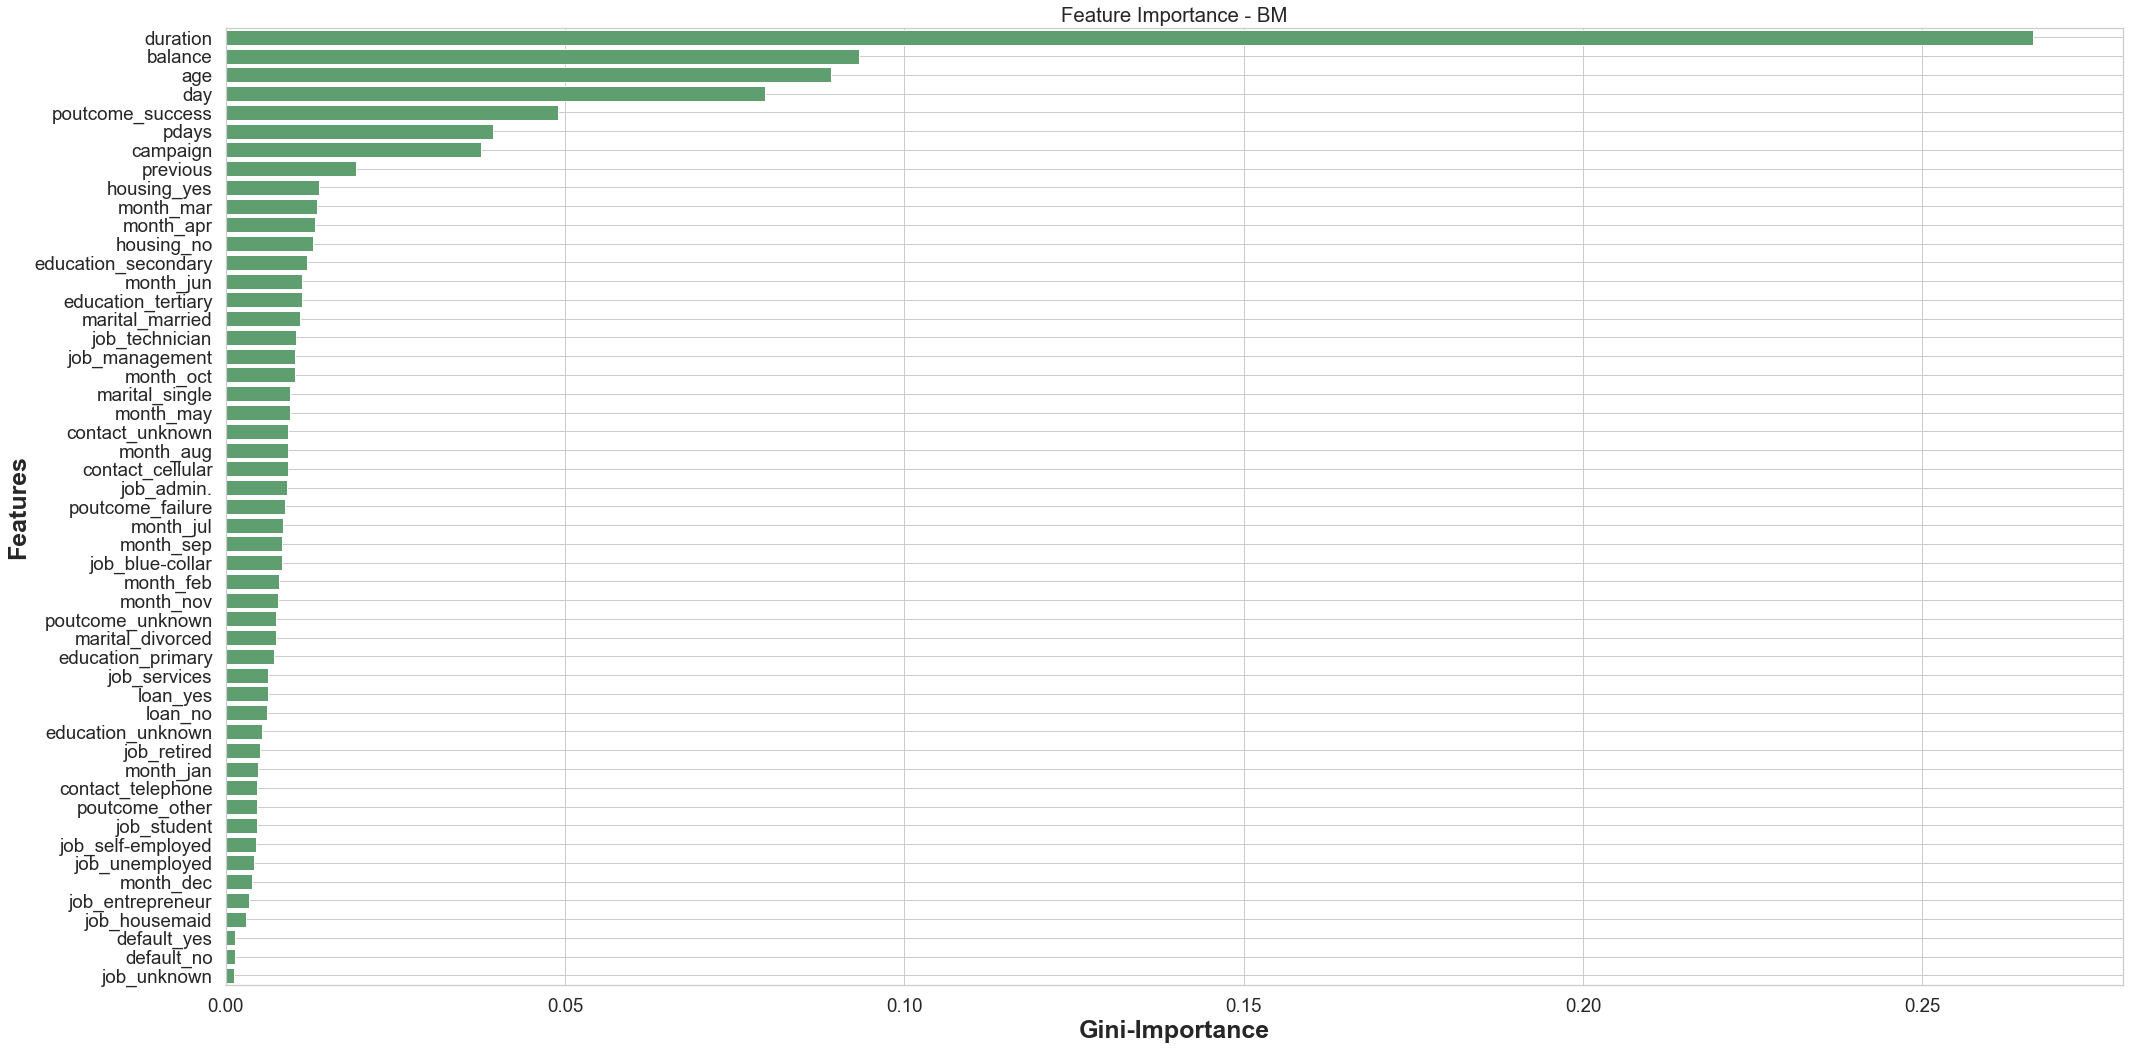

RandomForestClassifier()

In [56]:
run_RFC(X_train_scaled, y_train, DATASET)

# Apply Dimensionality Reduction on Datasets

In [28]:
# PCA
pca = PCA(n_components=8).fit(X_train_scaled)
X_pca = pca.transform(X_train_scaled)

start_time = time.time()
kmeans_pca = KMeans(2).fit(X_pca)
end_time = time.time()
train_duration_kmeans_pca = end_time - start_time

start_time = time.time()
kmeans_pca.predict(X_pca)
end_time = time.time()
query_duration_kmeans_pca = end_time - start_time

# ICA
ica = FastICA(n_components= 6).fit(X)
X_ica = ica.transform(X_train_scaled)

start_time = time.time()
kmeans_ica = KMeans(2).fit(X_ica)
end_time = time.time()
train_duration_kmeans_ica = end_time - start_time

start_time = time.time()
kmeans_ica.predict(X_ica)
end_time = time.time()
query_duration_kmeans_ica = end_time - start_time

# RFC


# Run Clustering Algorithms on Projected Data

# Run Neural Network on Projected Data

# Run Neural Network on Data Projected and Clustered